# Анализ данных о пневмонии с использованием PySpark

## Подготовка среды

В этом блокноте мы выполним анализ датасета metadata.csv, содержащего информацию о пациентах с различными типами пневмонии, включая COVID-19.

In [34]:
# Установка необходимых библиотек
!pip install pyspark findspark matplotlib seaborn plotly pandas numpy nbformat

  Using cached attrs-25.4.0-py3-none-any.whl.metadata (10 kB)
Using cached attrs-25.4.0-py3-none-any.whl (67 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [nbformat]


In [2]:
# Импорт необходимых библиотек
import findspark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

# Настройка findspark для локального использования
findspark.init()
print("Библиотеки успешно импортированы")

Библиотеки успешно импортированы


In [3]:
# Создание SparkSession
spark = SparkSession.builder \
    .appName("Covid-19 Metadata Analysis") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()

print(f"Spark Session создана: {spark.version}")
print(f"Spark UI доступен по адресу: {spark.sparkContext.uiWebUrl}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/14 11:42:41 WARN Utils: Your hostname, dmitrii-GH9, resolves to a loopback address: 127.0.1.1; using 192.168.31.45 instead (on interface wlo1)
25/12/14 11:42:41 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/14 11:42:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/12/14 11:42:42 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/12/14 11:42:42 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


Spark Session создана: 4.0.1
Spark UI доступен по адресу: http://192.168.31.45:4042


# Загрузка данных

In [4]:
# Загрузка данных из CSV файла
file_path = "data/metadata.csv"

# Чтение CSV файла
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Вывод информации о данных
print(f"Количество строк: {df.count()}")
print(f"Количество столбцов: {len(df.columns)}")

# Вывод схемы данных
print("\nСхема данных:")
df.printSchema()

# Просмотр первых нескольких строк
print("\nПервые 5 строк:")
df.show(5)


Количество строк: 950
Количество столбцов: 30

Схема данных:
root
 |-- patientid: string (nullable = true)
 |-- offset: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- finding: string (nullable = true)
 |-- RT_PCR_positive: string (nullable = true)
 |-- survival: string (nullable = true)
 |-- intubated: string (nullable = true)
 |-- intubation_present: string (nullable = true)
 |-- went_icu: string (nullable = true)
 |-- in_icu: string (nullable = true)
 |-- needed_supplemental_O2: string (nullable = true)
 |-- extubated: string (nullable = true)
 |-- temperature: double (nullable = true)
 |-- pO2_saturation: double (nullable = true)
 |-- leukocyte_count: double (nullable = true)
 |-- neutrophil_count: double (nullable = true)
 |-- lymphocyte_count: double (nullable = true)
 |-- view: string (nullable = true)
 |-- modality: string (nullable = true)
 |-- date: string (nullable = true)
 |-- location: string (nullable = true)
 |-- fold

25/12/14 11:44:24 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/12/14 11:44:24 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: patientid, offset, sex, age, finding, RT_PCR_positive, survival, intubated, intubation_present, went_icu, in_icu, needed_supplemental_O2, extubated, temperature, pO2_saturation, leukocyte_count, neutrophil_count, lymphocyte_count, view, modality, date, location, folder, filename, doi, url, license, clinical_notes, other_notes, 
 Schema: patientid, offset, sex, age, finding, RT_PCR_positive, survival, intubated, intubation_present, went_icu, in_icu, needed_supplemental_O2, extubated, temperature, pO2_saturation, leukocyte_count, neutrophil_count, lymphocyte_count, view, modality, date, location, folder, filename, doi, url, license, clinical_notes, other_notes, _c29
Expected: _c29 but found: 
CSV file: file:///

+---------+------+---+---+--------------------+---------------+--------+---------+------------------+--------+------+----------------------+---------+-----------+--------------+---------------+----------------+----------------+----+--------+----------------+--------------------+------+--------------------+--------------------+--------------------+-------+--------------------+-----------+----+
|patientid|offset|sex|age|             finding|RT_PCR_positive|survival|intubated|intubation_present|went_icu|in_icu|needed_supplemental_O2|extubated|temperature|pO2_saturation|leukocyte_count|neutrophil_count|lymphocyte_count|view|modality|            date|            location|folder|            filename|                 doi|                 url|license|      clinical_notes|other_notes|_c29|
+---------+------+---+---+--------------------+---------------+--------+---------+------------------+--------+------+----------------------+---------+-----------+--------------+---------------+---------------

# Предварительный осмотр данных

In [5]:
# Получение статистики по числовым колонкам
print("Статистика по числовым колонкам:")
df.describe().show()

Статистика по числовым колонкам:


25/12/14 11:44:44 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: patientid, offset, sex, age, finding, RT_PCR_positive, survival, intubated, intubation_present, went_icu, in_icu, needed_supplemental_O2, extubated, temperature, pO2_saturation, leukocyte_count, neutrophil_count, lymphocyte_count, view, modality, date, location, folder, filename, doi, url, license, clinical_notes, other_notes, 
 Schema: patientid, offset, sex, age, finding, RT_PCR_positive, survival, intubated, intubation_present, went_icu, in_icu, needed_supplemental_O2, extubated, temperature, pO2_saturation, leukocyte_count, neutrophil_count, lymphocyte_count, view, modality, date, location, folder, filename, doi, url, license, clinical_notes, other_notes, _c29
Expected: _c29 but found: 
CSV file: file:///home/dmitrii/repo/learn/miphi/sem-3/bigdata/data/metadata.csv


+-------+------------------+------------------+----+------------------+----------+---------------+--------+---------+------------------+--------+------+----------------------+---------+------------------+-----------------+------------------+------------------+------------------+----+--------+------------------+------------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|summary|         patientid|            offset| sex|               age|   finding|RT_PCR_positive|survival|intubated|intubation_present|went_icu|in_icu|needed_supplemental_O2|extubated|       temperature|   pO2_saturation|   leukocyte_count|  neutrophil_count|  lymphocyte_count|view|modality|              date|          location| folder|            filename|                 doi|                 url|             license|      clinical_notes|         other_notes|                _c29|
+-------+-----------------

In [6]:
# Просмотр уникальных значений в важных колонках
print("Уникальные значения в колонке 'finding':")
df.select('finding').distinct().show(truncate=False)

print("Уникальные значения в колонке 'sex':")
df.select('sex').distinct().show()

print("Уникальные значения в колонке 'view':")
df.select('view').distinct().show(truncate=False)

Уникальные значения в колонке 'finding':
+---------------------------------------+
|finding                                |
+---------------------------------------+
|Pneumonia/Bacterial/Streptococcus      |
|Pneumonia/Aspiration                   |
|Pneumonia/Lipoid                       |
|Tuberculosis                           |
|Pneumonia/Fungal/Pneumocystis          |
|Pneumonia/Bacterial/Klebsiella         |
|Pneumonia/Bacterial                    |
|Pneumonia/Viral/MERS-CoV               |
|Unknown                                |
|Pneumonia/Viral/Varicella              |
|Pneumonia/Bacterial/Staphylococcus/MRSA|
|Pneumonia/Viral/Influenza/H1N1         |
|Pneumonia/Bacterial/Nocardia           |
|todo                                   |
|Pneumonia/Bacterial/Mycoplasma         |
|Pneumonia/Viral/Influenza              |
|Pneumonia/Viral/COVID-19               |
|Pneumonia/Viral/SARS                   |
|Pneumonia/Bacterial/Legionella         |
|Pneumonia/Fungal/Aspergillosis    

# Предобработка данных

In [8]:
# Проверка пропущенных значений
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+------+---+---+-------+---------------+--------+---------+------------------+--------+------+----------------------+---------+-----------+--------------+---------------+----------------+----------------+----+--------+----+--------+------+--------+---+---+-------+--------------+-----------+----+
|patientid|offset|sex|age|finding|RT_PCR_positive|survival|intubated|intubation_present|went_icu|in_icu|needed_supplemental_O2|extubated|temperature|pO2_saturation|leukocyte_count|neutrophil_count|lymphocyte_count|view|modality|date|location|folder|filename|doi|url|license|clinical_notes|other_notes|_c29|
+---------+------+---+---+-------+---------------+--------+---------+------------------+--------+------+----------------------+---------+-----------+--------------+---------------+----------------+----------------+----+--------+----+--------+------+--------+---+---+-------+--------------+-----------+----+
|        0|   253| 80|237|      0|            357|     589|      702|          

25/12/14 11:48:07 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: patientid, offset, sex, age, finding, RT_PCR_positive, survival, intubated, intubation_present, went_icu, in_icu, needed_supplemental_O2, extubated, temperature, pO2_saturation, leukocyte_count, neutrophil_count, lymphocyte_count, view, modality, date, location, folder, filename, doi, url, license, clinical_notes, other_notes, 
 Schema: patientid, offset, sex, age, finding, RT_PCR_positive, survival, intubated, intubation_present, went_icu, in_icu, needed_supplemental_O2, extubated, temperature, pO2_saturation, leukocyte_count, neutrophil_count, lymphocyte_count, view, modality, date, location, folder, filename, doi, url, license, clinical_notes, other_notes, _c29
Expected: _c29 but found: 
CSV file: file:///home/dmitrii/repo/learn/miphi/sem-3/bigdata/data/metadata.csv


In [10]:
# Создание новой версии датафрейма с обработанными пропусками
# Заполнение пропусков в числовых колонках средним значением или медианой
# Заполнение пропусков в строковых колонках значением 'Unknown'

# Сначала выведем статистику по пропускам более подробно
missing_values = []
for col_name in df.columns:
    null_count = df.filter(col(col_name).isNull() | (trim(col(col_name)) == "")).count()
    missing_values.append((col_name, null_count, f"{null_count/df.count()*100:.2f}%"))

missing_df = spark.createDataFrame(missing_values, ["Column", "Missing_Count", "Percentage"])
missing_df.show(100)

25/12/14 11:52:19 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 
 Schema: _c29
Expected: _c29 but found: 
CSV file: file:///home/dmitrii/repo/learn/miphi/sem-3/bigdata/data/metadata.csv


+--------------------+-------------+----------+
|              Column|Missing_Count|Percentage|
+--------------------+-------------+----------+
|           patientid|            0|     0.00%|
|              offset|          253|    26.63%|
|                 sex|           80|     8.42%|
|                 age|          237|    24.95%|
|             finding|            0|     0.00%|
|     RT_PCR_positive|          357|    37.58%|
|            survival|          589|    62.00%|
|           intubated|          702|    73.89%|
|  intubation_present|          700|    73.68%|
|            went_icu|          553|    58.21%|
|              in_icu|          615|    64.74%|
|needed_supplement...|          860|    90.53%|
|           extubated|          913|    96.11%|
|         temperature|          872|    91.79%|
|      pO2_saturation|          831|    87.47%|
|     leukocyte_count|          934|    98.32%|
|    neutrophil_count|          922|    97.05%|
|    lymphocyte_count|          910|    

In [11]:
# Заполнение пропусков в числовых колонках медианой
# Сначала определим числовые колонки
numeric_cols = []
for field in df.schema.fields:
    if isinstance(field.dataType, (IntegerType, LongType, FloatType, DoubleType)):
        numeric_cols.append(field.name)

print(f"Числовые колонки: {numeric_cols}")

# Заполнение пропусков в строковых колонках значением 'Unknown'
string_cols = []
for field in df.schema.fields:
    if isinstance(field.dataType, StringType):
        string_cols.append(field.name)

print(f"Строковые колонки: {string_cols}")

Числовые колонки: ['offset', 'age', 'temperature', 'pO2_saturation', 'leukocyte_count', 'neutrophil_count', 'lymphocyte_count']
Строковые колонки: ['patientid', 'sex', 'finding', 'RT_PCR_positive', 'survival', 'intubated', 'intubation_present', 'went_icu', 'in_icu', 'needed_supplemental_O2', 'extubated', 'view', 'modality', 'date', 'location', 'folder', 'filename', 'doi', 'url', 'license', 'clinical_notes', 'other_notes', '_c29']


In [13]:
# Обработка числовых колонок - заполнение медианой
df_processed = df

for col_name in numeric_cols:
    # Вычисляем медиану для колонки
    median_val = df.approxQuantile(col_name, [0.5], 0)[0]
    print(f"Медиана для колонки {col_name}: {median_val}")
    
    # Заменяем NULL значения на медиану
    df_processed = df_processed.fillna({col_name: median_val})

# Обработка строковых колонок - заполнение 'Unknown'
for col_name in string_cols:
    df_processed = df_processed.fillna({col_name: 'Unknown'})
    
# Также заменяем пустые строки на 'Unknown'
for col_name in string_cols:
    df_processed = df_processed.withColumn(col_name, 
                                         when(trim(col(col_name)) == "", "Unknown")
                                         .otherwise(col(col_name)))

print("Обработка пропусков завершена")

# Проверим снова количество пропусков
print("\nКоличество пропущенных значений после обработки:")
for col_name in df_processed.columns:
    null_count = df_processed.filter(col(col_name).isNull()).count()
    if null_count > 0:
        print(f"{col_name}: {null_count} ({null_count/df_processed.count()*100:.2f}%)")

Медиана для колонки offset: 5.0
Медиана для колонки age: 54.0
Медиана для колонки temperature: 38.1
Медиана для колонки pO2_saturation: 85.0
Медиана для колонки leukocyte_count: 3.99
Медиана для колонки neutrophil_count: 4.5
Медиана для колонки lymphocyte_count: 1.1
Обработка пропусков завершена

Количество пропущенных значений после обработки:


In [14]:
# Унификация диагнозов (finding) - приведение к стандартным значениям
df_processed = df_processed.withColumn(
    "finding_unified",
    when(lower(col("finding")).contains("covid"), "COVID-19")
    .when(lower(col("finding")).contains("pneumonia") & ~lower(col("finding")).contains("covid"), "Pneumonia")
    .when(lower(col("finding")).contains("normal"), "Normal")
    .when(lower(col("finding")).contains("sars"), "SARS")
    .when(lower(col("finding")).contains("mers"), "MERS")
    .when(lower(col("finding")).contains("tuberculosis"), "Tuberculosis")
    .otherwise(col("finding"))
)

print("Унификация диагнозов завершена")
print("\nУникальные значения унифицированного диагноза:")
df_processed.select('finding_unified').distinct().show(truncate=False)

Унификация диагнозов завершена

Уникальные значения унифицированного диагноза:


+---------------+
|finding_unified|
+---------------+
|Tuberculosis   |
|Unknown        |
|COVID-19       |
|todo           |
|No Finding     |
|Pneumonia      |
+---------------+



# Анализ качества данных

25/12/14 11:55:15 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 
 Schema: _c29
Expected: _c29 but found: 
CSV file: file:///home/dmitrii/repo/learn/miphi/sem-3/bigdata/data/metadata.csv


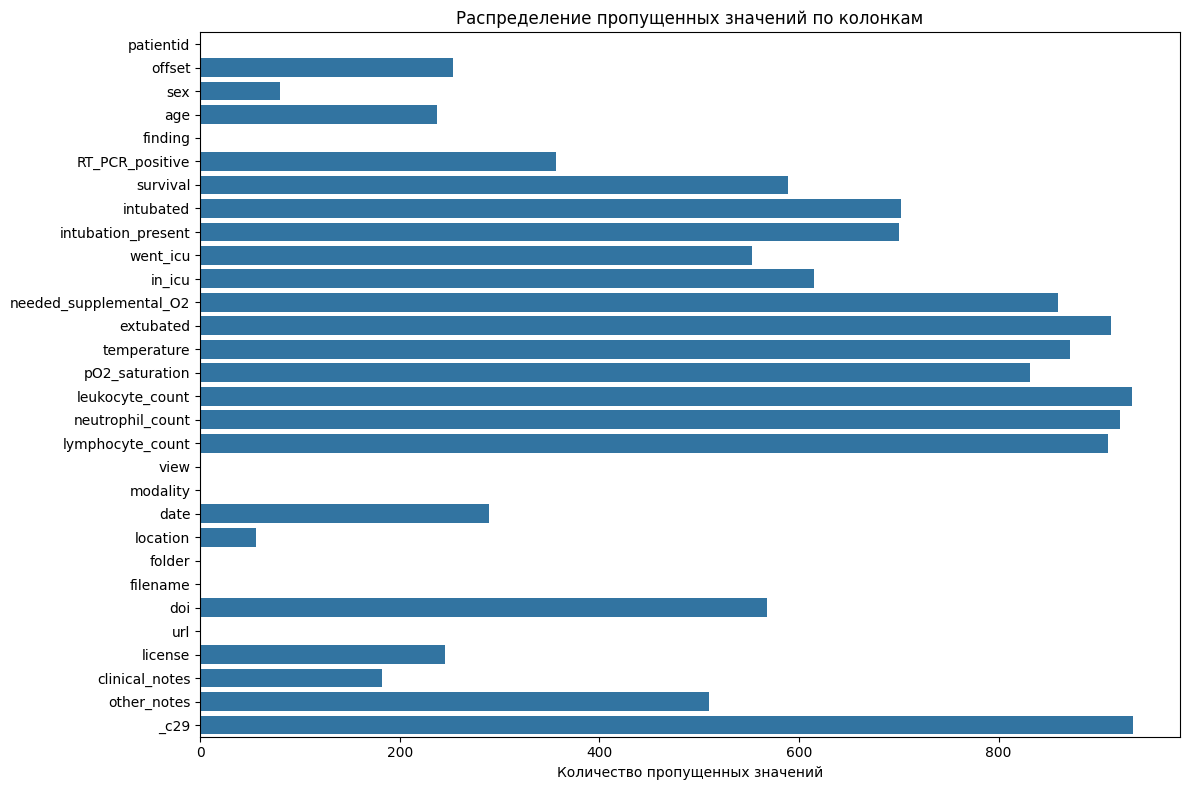

In [16]:
# Визуализация распределения пропущенных значений
import matplotlib.pyplot as plt
import seaborn as sns

# Подсчет пропущенных значений для каждой колонки
missing_counts = []
columns = []

for col_name in df.columns:
    null_count = df.filter(col(col_name).isNull()).count()
    missing_counts.append(null_count)
    columns.append(col_name)

# Создание графика
plt.figure(figsize=(12, 8))
sns.barplot(x=missing_counts, y=columns)
plt.title('Распределение пропущенных значений по колонкам')
plt.xlabel('Количество пропущенных значений')
plt.tight_layout()
plt.show()


Анализ колонки age:
Среднее: 53.65, Стандартное отклонение: 14.68
Минимум: 18, Максимум: 94
Количество выбросов (IQR метод): 9


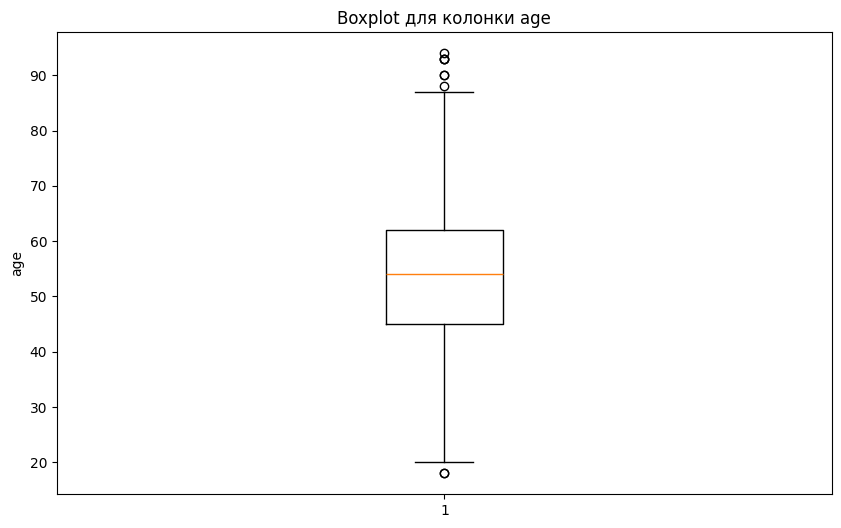


Анализ колонки temperature:
Среднее: 38.17, Стандартное отклонение: 1.86
Минимум: 36.0, Максимум: 95.0
Количество выбросов (IQR метод): 75


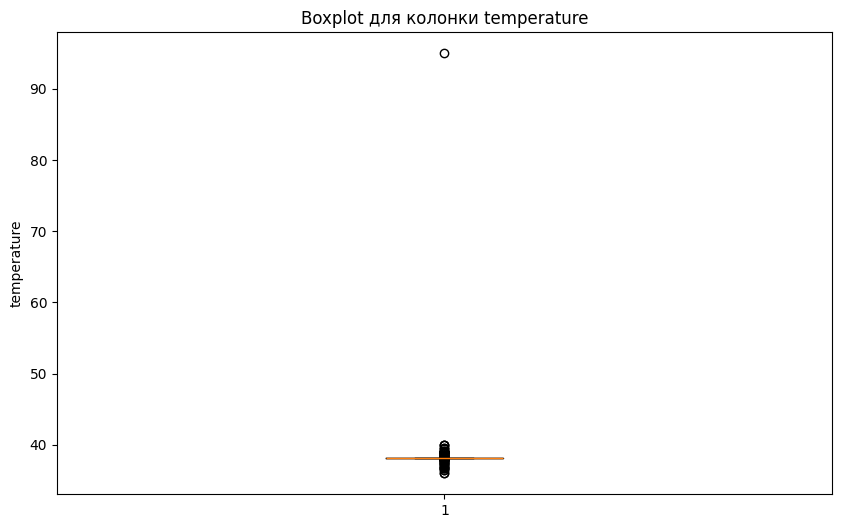


Анализ колонки pO2_saturation:
Среднее: 84.18, Стандартное отклонение: 13.83
Минимум: 20.0, Максимум: 340.0
Количество выбросов (IQR метод): 113


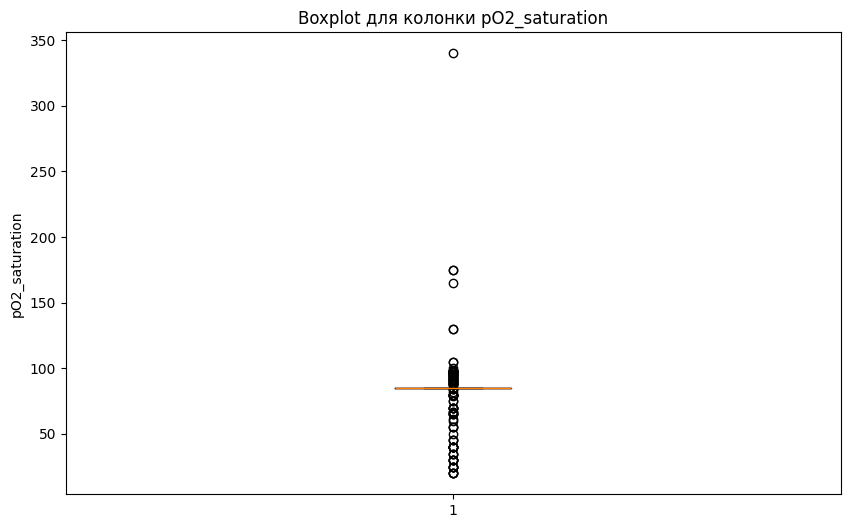


Анализ колонки leukocyte_count:
Среднее: 4.01, Стандартное отклонение: 0.36
Минимум: 0.22, Максимум: 11.2
Количество выбросов (IQR метод): 15


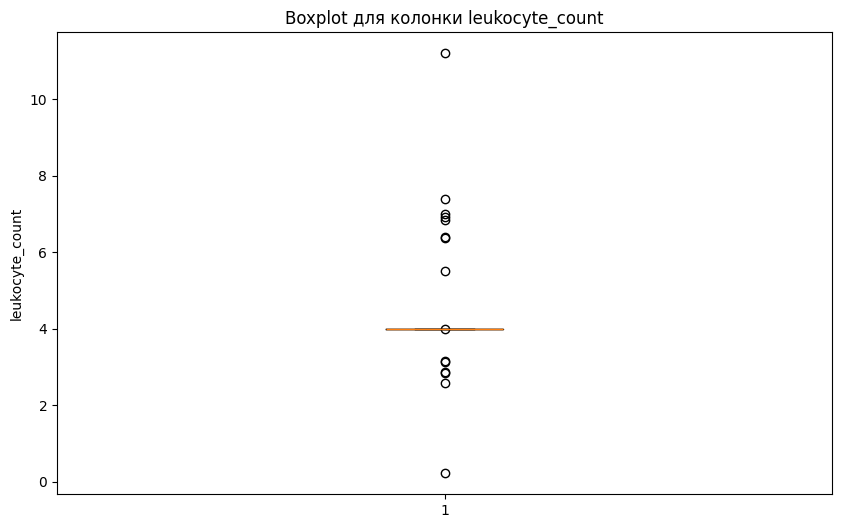


Анализ колонки neutrophil_count:
Среднее: 4.52, Стандартное отклонение: 0.60
Минимум: 0.0, Максимум: 12.9
Количество выбросов (IQR метод): 27


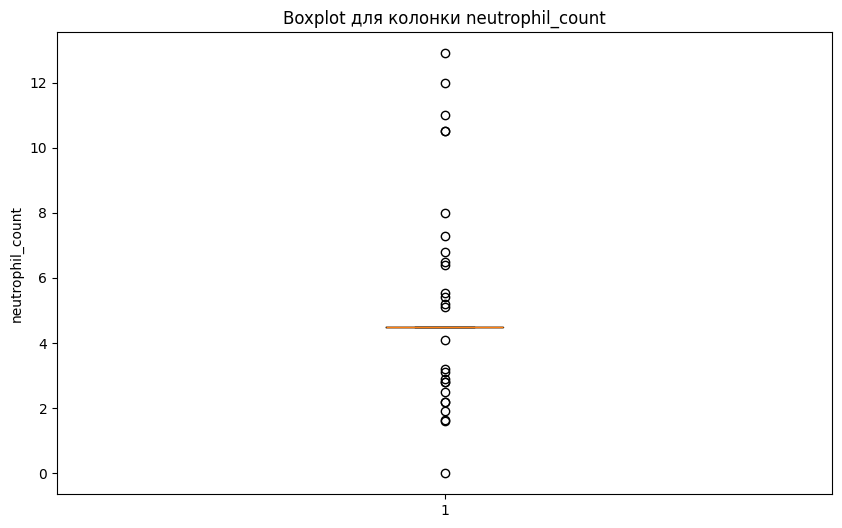


Анализ колонки lymphocyte_count:
Среднее: 1.25, Стандартное отклонение: 4.23
Минимум: 0.4, Максимум: 131.0
Количество выбросов (IQR метод): 36


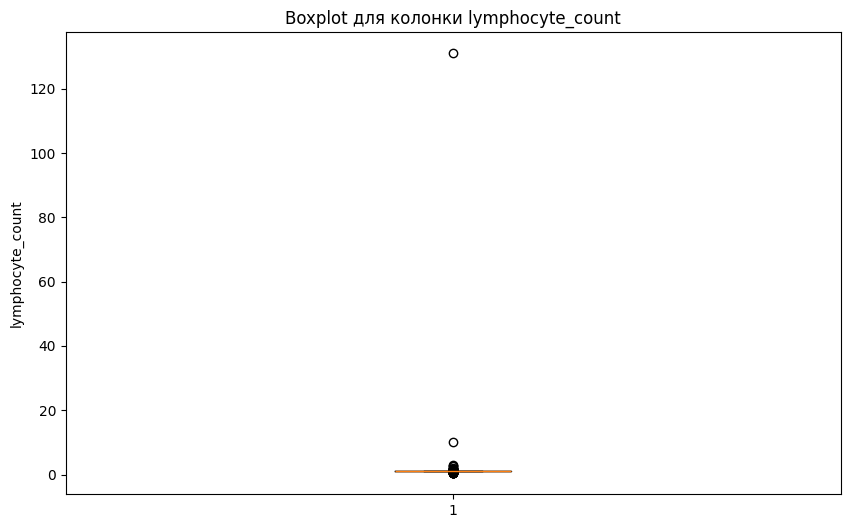

In [17]:
# Выявление аномальных значений в числовых колонках
for col_name in numeric_cols:
    if col_name != 'offset':  # Пропустим offset, так как это вспомогательное поле
        print(f"\nАнализ колонки {col_name}:")
        
        # Статистика
        stats = df_processed.select(
            mean(col_name).alias('mean'),
            stddev(col_name).alias('stddev'),
            min(col_name).alias('min'),
            max(col_name).alias('max')
        ).collect()[0]
        
        print(f"Среднее: {stats['mean']:.2f}, Стандартное отклонение: {stats['stddev']:.2f}")
        print(f"Минимум: {stats['min']}, Максимум: {stats['max']}")
        
        # Выявление выбросов с помощью метода IQR
        q1 = df_processed.approxQuantile(col_name, [0.25], 0)[0]
        q3 = df_processed.approxQuantile(col_name, [0.75], 0)[0]
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        outliers_count = df_processed.filter(
            (col(col_name) < lower_bound) | (col(col_name) > upper_bound)
        ).count()
        
        print(f"Количество выбросов (IQR метод): {outliers_count}")
        
        # Визуализация
        plt.figure(figsize=(10, 6))
        df_pd = df_processed.select(col_name).filter(col(col_name).isNotNull()).toPandas()
        plt.boxplot(df_pd[col_name])
        plt.title(f'Boxplot для колонки {col_name}')
        plt.ylabel(col_name)
        plt.show()

# SQL-аналитика

In [18]:
# Регистрация таблицы для SQL-запросов
df_processed.createOrReplaceTempView("metadata")

# Запрос 1: Базовая статистика по диагнозам
print("Запрос 1: Базовая статистика по диагнозам")
query1 = """
SELECT 
    finding_unified,
    COUNT(*) as count,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM metadata), 2) as percentage
FROM metadata
GROUP BY finding_unified
ORDER BY count DESC
"""
result1 = spark.sql(query1)
result1.show(100)

Запрос 1: Базовая статистика по диагнозам
+---------------+-----+----------+
|finding_unified|count|percentage|
+---------------+-----+----------+
|       COVID-19|  584|     61.47|
|      Pneumonia|  242|     25.47|
|           todo|   83|      8.74|
|     No Finding|   22|      2.32|
|   Tuberculosis|   18|      1.89|
|        Unknown|    1|      0.11|
+---------------+-----+----------+



In [19]:
# Запрос 2: Распределение по полу и диагнозам
print("Запрос 2: Распределение по полу и диагнозам")
query2 = """
SELECT 
    sex,
    finding_unified,
    COUNT(*) as count
FROM metadata
WHERE sex != 'Unknown'
GROUP BY sex, finding_unified
ORDER BY sex, count DESC
"""
result2 = spark.sql(query2)
result2.show(100)

Запрос 2: Распределение по полу и диагнозам
+---+---------------+-----+
|sex|finding_unified|count|
+---+---------------+-----+
|  F|       COVID-19|  175|
|  F|      Pneumonia|   98|
|  F|           todo|   23|
|  F|     No Finding|   10|
|  F|   Tuberculosis|    5|
|  M|       COVID-19|  346|
|  M|      Pneumonia|  129|
|  M|           todo|   59|
|  M|   Tuberculosis|   13|
|  M|     No Finding|   11|
|  M|        Unknown|    1|
+---+---------------+-----+



In [22]:
# Запрос 3: Оконная функция (топ-3 по возрасту в каждой группе диагнозов)
print("Запрос 3: Топ-3 пациентов по возрасту в каждой группе диагнозов")
query3 = """
SELECT 
    finding_unified,
    patientid,
    age,
    sex,
    rank_by_age
FROM (
    SELECT 
        finding_unified,
        patientid,
        age,
        sex,
        ROW_NUMBER() OVER (PARTITION BY finding_unified ORDER BY age DESC) as rank_by_age
    FROM metadata
    WHERE age IS NOT NULL
) ranked
WHERE rank_by_age <= 3
ORDER BY finding_unified, rank_by_age

"""
result3 = spark.sql(query3)
result3.show(100)

Запрос 3: Топ-3 пациентов по возрасту в каждой группе диагнозов
+---------------+---------+---+---+-----------+
|finding_unified|patientid|age|sex|rank_by_age|
+---------------+---------+---+---+-----------+
|       COVID-19|     326b| 94|  M|          1|
|       COVID-19|     324b| 93|  F|          2|
|       COVID-19|     324b| 93|  F|          3|
|     No Finding|      315| 78|  F|          1|
|     No Finding|      325| 78|  F|          2|
|     No Finding|     313b| 75|  M|          3|
|      Pneumonia|      460| 90|  M|          1|
|      Pneumonia|      460| 90|  M|          2|
|      Pneumonia|       91| 80|  F|          3|
|   Tuberculosis|      421| 78|  M|          1|
|   Tuberculosis|      453| 70|  M|          2|
|   Tuberculosis|      456| 58|  M|          3|
|        Unknown|      221| 54|  M|          1|
|           todo|      384| 54|  M|          1|
|           todo|      385| 54|  M|          2|
|           todo|      386| 54|  M|          3|
+---------------+-------

In [23]:
# Запрос 4: Анализ временных трендов по датам исследований
print("Запрос 4: Анализ временных трендов по датам исследований")
query4 = """
SELECT 
    date,
    finding_unified,
    COUNT(*) as count
FROM metadata
WHERE date != 'Unknown' AND date IS NOT NULL
GROUP BY date, finding_unified
ORDER BY date, count DESC
LIMIT 20
"""
result4 = spark.sql(query4)
result4.show(20)

Запрос 4: Анализ временных трендов по датам исследований
+-------------+---------------+-----+
|         date|finding_unified|count|
+-------------+---------------+-----+
|     01/13/20|       COVID-19|    1|
|     03/06/20|       COVID-19|    1|
|     03/09/20|      Pneumonia|    2|
|     03/16/20|       COVID-19|    2|
|     11/27/19|      Pneumonia|    2|
|12 March 2020|     No Finding|    1|
|    2/29/2020|       COVID-19|    2|
|         2004|      Pneumonia|   11|
|         2007|      Pneumonia|    1|
|         2010|      Pneumonia|    3|
|         2011|      Pneumonia|    5|
|         2013|      Pneumonia|    7|
|         2014|      Pneumonia|   11|
|         2015|      Pneumonia|   24|
|         2016|      Pneumonia|   20|
|         2017|      Pneumonia|    3|
|         2018|      Pneumonia|    6|
|         2019|     No Finding|    2|
|         2020|       COVID-19|  364|
|         2020|           todo|   82|
+-------------+---------------+-----+



In [24]:
# Запрос 5: Статистика по проекциям снимков и их связи с диагнозами
print("Запрос 5: Статистика по проекциям снимков и их связи с диагнозами")
query5 = """
SELECT 
    view,
    finding_unified,
    COUNT(*) as count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY finding_unified), 2) as percentage_within_diagnosis
FROM metadata
WHERE view != 'Unknown' AND finding_unified != 'Unknown'
GROUP BY view, finding_unified
ORDER BY finding_unified, count DESC
"""
result5 = spark.sql(query5)
result5.show(100)

Запрос 5: Статистика по проекциям снимков и их связи с диагнозами
+---------+---------------+-----+---------------------------+
|     view|finding_unified|count|percentage_within_diagnosis|
+---------+---------------+-----+---------------------------+
|       PA|       COVID-19|  196|                      33.56|
|       AP|       COVID-19|  146|                      25.00|
|AP Supine|       COVID-19|  136|                      23.29|
|    Axial|       COVID-19|   64|                      10.96|
|        L|       COVID-19|   26|                       4.45|
|  Coronal|       COVID-19|   16|                       2.74|
|       PA|     No Finding|   10|                      45.45|
|       AP|     No Finding|    5|                      22.73|
|    Axial|     No Finding|    4|                      18.18|
|AP Supine|     No Finding|    3|                      13.64|
|       PA|      Pneumonia|  117|                      48.35|
|        L|      Pneumonia|   51|                      21.07|
|   

# Использование UDF (пользовательские функции)

In [25]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Создание UDF для категоризации возраста
def categorize_age(age):
    if age is None or age == 'Unknown':
        return 'Unknown'
    age = float(age) if str(age).replace('.', '').isdigit() else 0
    if age < 18:
        return 'Child'
    elif age < 30:
        return 'Young Adult'
    elif age < 50:
        return 'Middle Age'
    elif age < 65:
        return 'Senior'
    else:
        return 'Elderly'

# Регистрация UDF
categorize_age_udf = udf(lambda age: categorize_age(age), StringType())

# Применение UDF к датафрейму
df_with_age_category = df_processed.withColumn("age_category", categorize_age_udf(col("age")))

print("Категоризация возраста завершена")
print("\nРаспределение по возрастным категориям:")
df_with_age_category.groupBy("age_category").count().orderBy(desc("count")).show()

Категоризация возраста завершена

Распределение по возрастным категориям:
+------------+-----+
|age_category|count|
+------------+-----+
|      Senior|  455|
|     Elderly|  219|
|  Middle Age|  210|
| Young Adult|   66|
+------------+-----+



In [26]:
# Применение UDF для унификации диагнозов (альтернативный способ)
def unify_diagnosis(diagnosis):
    if diagnosis is None or diagnosis == 'Unknown':
        return 'Unknown'
    diagnosis_lower = diagnosis.lower()
    if 'covid' in diagnosis_lower:
        return 'COVID-19'
    elif 'pneumonia' in diagnosis_lower and 'covid' not in diagnosis_lower:
        return 'Pneumonia'
    elif 'normal' in diagnosis_lower:
        return 'Normal'
    elif 'sars' in diagnosis_lower:
        return 'SARS'
    elif 'mers' in diagnosis_lower:
        return 'MERS'
    elif 'tuberculosis' in diagnosis_lower:
        return 'Tuberculosis'
    else:
        return diagnosis

# Регистрация UDF
unify_diagnosis_udf = udf(lambda diagnosis: unify_diagnosis(diagnosis), StringType())

# Создание дополнительной колонки с унифицированным диагнозом
df_with_unified_diagnosis = df_with_age_category.withColumn("finding_unified_v2", 
                                                            unify_diagnosis_udf(col("finding")))

print("Унификация диагнозов с помощью UDF завершена")
print("\nСравнение оригинальных и унифицированных диагнозов:")
df_with_unified_diagnosis.select('finding', 'finding_unified', 'finding_unified_v2').distinct().show(50, truncate=False)

Унификация диагнозов с помощью UDF завершена

Сравнение оригинальных и унифицированных диагнозов:
+---------------------------------------+---------------+------------------+
|finding                                |finding_unified|finding_unified_v2|
+---------------------------------------+---------------+------------------+
|Pneumonia/Bacterial                    |Pneumonia      |Pneumonia         |
|Pneumonia/Bacterial/Nocardia           |Pneumonia      |Pneumonia         |
|Pneumonia/Viral/Herpes                 |Pneumonia      |Pneumonia         |
|Pneumonia/Bacterial/Streptococcus      |Pneumonia      |Pneumonia         |
|Pneumonia/Bacterial/Chlamydophila      |Pneumonia      |Pneumonia         |
|Pneumonia/Bacterial/E.Coli             |Pneumonia      |Pneumonia         |
|Pneumonia/Lipoid                       |Pneumonia      |Pneumonia         |
|Pneumonia/Aspiration                   |Pneumonia      |Pneumonia         |
|Pneumonia                              |Pneumonia     

# Базовая обработка и фильтрация данных

In [27]:
# Фильтрация данных по заданным критериям
# Например, выбор только пациентов с COVID-19 старше 18 лет

covid_adults = df_with_unified_diagnosis.filter(
    (col('finding_unified') == 'COVID-19') & 
    (col('age') >= 18) & 
    (col('age').isNotNull())
)

print(f"Количество взрослых пациентов с COVID-19: {covid_adults.count()}")
covid_adults.select('patientid', 'age', 'sex', 'finding_unified').show(10)

Количество взрослых пациентов с COVID-19: 584
+---------+---+-------+---------------+
|patientid|age|    sex|finding_unified|
+---------+---+-------+---------------+
|        2| 65|      M|       COVID-19|
|        2| 65|      M|       COVID-19|
|        2| 65|      M|       COVID-19|
|        2| 65|      M|       COVID-19|
|        4| 52|      F|       COVID-19|
|        4| 52|      F|       COVID-19|
|        6| 54|Unknown|       COVID-19|
|        6| 54|Unknown|       COVID-19|
|       11| 56|      M|       COVID-19|
|       12| 42|      M|       COVID-19|
+---------+---+-------+---------------+
only showing top 10 rows


In [28]:
# Сохранение результатов в оптимизированном формате (Parquet)
output_path = "data/metadata_processed.parquet"

# Сохранение обработанного датафрейма
df_with_unified_diagnosis.write.mode("overwrite").parquet(output_path)

print(f"Обработанные данные сохранены в: {output_path}")

# Чтение и проверка сохраненных данных
df_read = spark.read.parquet(output_path)
print(f"Количество строк в прочитанном файле: {df_read.count()}")
df_read.show(5)

25/12/14 12:04:30 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: patientid, offset, sex, age, finding, RT_PCR_positive, survival, intubated, intubation_present, went_icu, in_icu, needed_supplemental_O2, extubated, temperature, pO2_saturation, leukocyte_count, neutrophil_count, lymphocyte_count, view, modality, date, location, folder, filename, doi, url, license, clinical_notes, other_notes, 
 Schema: patientid, offset, sex, age, finding, RT_PCR_positive, survival, intubated, intubation_present, went_icu, in_icu, needed_supplemental_O2, extubated, temperature, pO2_saturation, leukocyte_count, neutrophil_count, lymphocyte_count, view, modality, date, location, folder, filename, doi, url, license, clinical_notes, other_notes, _c29
Expected: _c29 but found: 
CSV file: file:///home/dmitrii/repo/learn/miphi/sem-3/bigdata/data/metadata.csv


Обработанные данные сохранены в: data/metadata_processed.parquet
Количество строк в прочитанном файле: 950
+---------+------+---+---+--------------------+---------------+--------+---------+------------------+--------+------+----------------------+---------+-----------+--------------+---------------+----------------+----------------+----+--------+----------------+--------------------+------+--------------------+--------------------+--------------------+-------+--------------------+-----------+-------+---------------+------------+------------------+
|patientid|offset|sex|age|             finding|RT_PCR_positive|survival|intubated|intubation_present|went_icu|in_icu|needed_supplemental_O2|extubated|temperature|pO2_saturation|leukocyte_count|neutrophil_count|lymphocyte_count|view|modality|            date|            location|folder|            filename|                 doi|                 url|license|      clinical_notes|other_notes|   _c29|finding_unified|age_category|finding_unified_v2|

# Визуализация

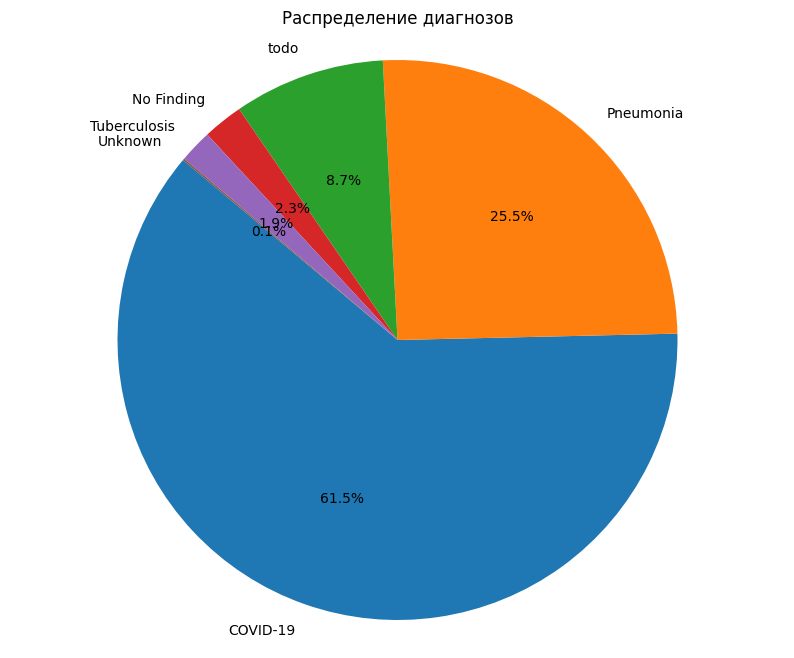

In [29]:
# Подготовка данных для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd

# 1. Круговая диаграмма распределения диагнозов
diagnosis_counts = df_processed.groupBy('finding_unified').count().orderBy(desc('count'))
diagnosis_pd = diagnosis_counts.toPandas()

plt.figure(figsize=(10, 8))
plt.pie(diagnosis_pd['count'], labels=diagnosis_pd['finding_unified'], autopct='%1.1f%%', startangle=140)
plt.title('Распределение диагнозов')
plt.axis('equal')
plt.show()

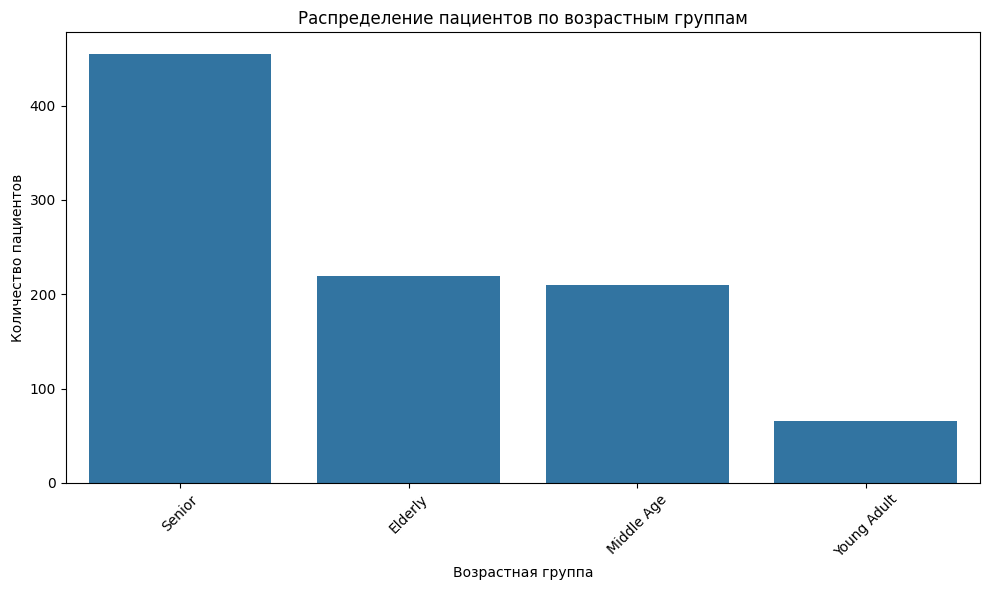

In [30]:
# 2. Столбчатая диаграмма по возрастным группам
age_category_counts = df_with_age_category.groupBy('age_category').count().orderBy(desc('count'))
age_category_pd = age_category_counts.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=age_category_pd, x='age_category', y='count')
plt.title('Распределение пациентов по возрастным группам')
plt.xlabel('Возрастная группа')
plt.ylabel('Количество пациентов')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

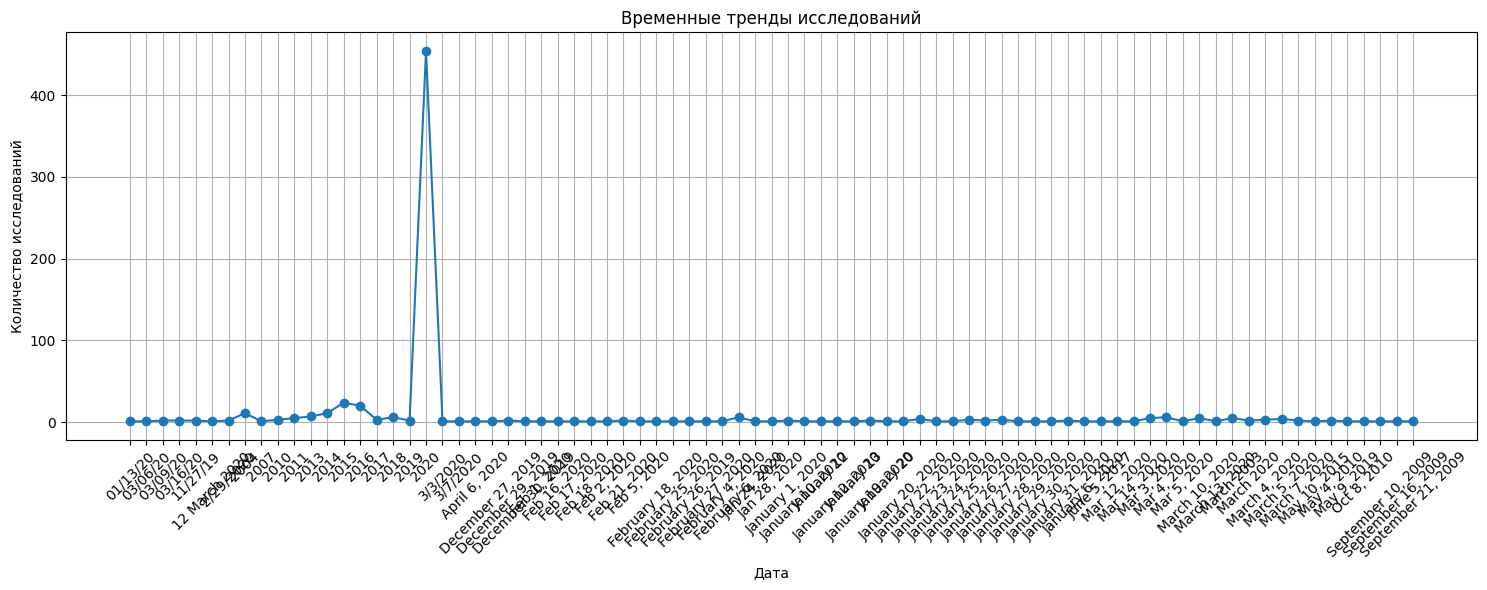

In [31]:
# 3. График временных трендов исследований
time_trends = df_processed.filter(col('date') != 'Unknown').groupBy('date').count().orderBy('date')
time_trends_pd = time_trends.toPandas()

plt.figure(figsize=(15, 6))
plt.plot(time_trends_pd['date'], time_trends_pd['count'], marker='o')
plt.title('Временные тренды исследований')
plt.xlabel('Дата')
plt.ylabel('Количество исследований')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

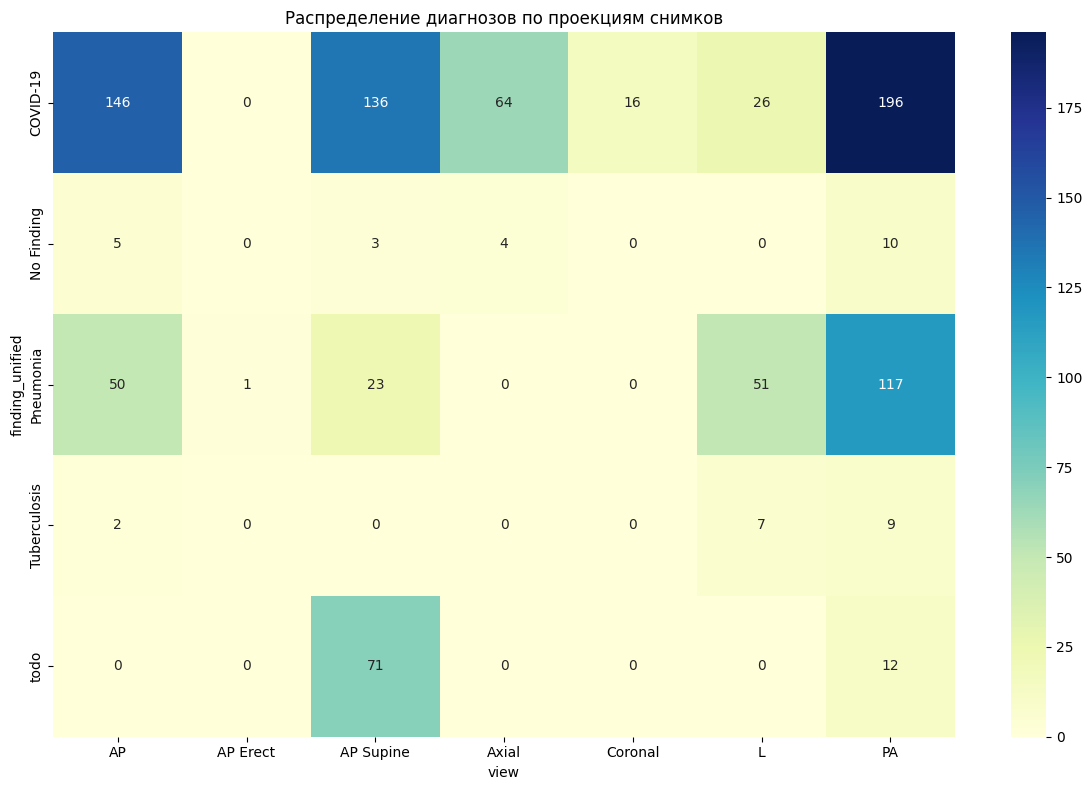

In [32]:
# 4. Heatmap распределения диагнозов по проекциям снимков
heatmap_data = df_processed.filter(
    (col('view') != 'Unknown') & (col('finding_unified') != 'Unknown')
).groupBy('view', 'finding_unified').count()

# Преобразование в Pandas DataFrame для построения heatmap
heatmap_pd = heatmap_data.toPandas()
heatmap_pivot = heatmap_pd.pivot(index='finding_unified', columns='view', values='count').fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_pivot, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Распределение диагнозов по проекциям снимков')
plt.tight_layout()
plt.show()

In [36]:
# Интерактивная визуализация с Plotly
# Диаграмма распределения диагнозов
fig = px.pie(diagnosis_pd, values='count', names='finding_unified', title='Распределение диагнозов')
fig.show()

# Столбчатая диаграмма по возрастным группам
fig = px.bar(age_category_pd, x='age_category', y='count', title='Распределение пациентов по возрастным группам')
fig.show()

# Временные тренды
fig = px.line(time_trends_pd, x='date', y='count', title='Временные тренды исследований')
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

# Завершение работы

In [37]:
# Завершение сессии Spark
spark.stop()
print("SparkSession остановлена")

SparkSession остановлена
